## Overview of RNN and LSTM

### Recurrent Neural Networks (RNNs)
Recurrent Neural Networks (RNNs) are designed for sequential data. Unlike traditional feedforward networks, RNNs have cycles that allow information to persist over sequences, making them suitable for tasks like language modeling and time series prediction.

### Long Short-Term Memory (LSTM)
LSTM units are a specialized type of RNN that address limitations such as vanishing gradients. They manage long-term dependencies using three components:
1. **Forget Gate:** Decides what information to discard from the cell state.
2. **Input Gate:** Determines which input values to add to the cell state.
3. **Output Gate:** Controls what information to output from the cell state.

## LSTM in This Code

### Model Architecture
- **Embedding Layer:** Converts words to dense vectors (1024-dimensional).
- **Bidirectional LSTM Layer:** Processes sequences in both directions to capture context.
- **Dense Layer:** Outputs predictions for each word in the vocabulary.
- **Activation Layer:** Uses softmax to predict the next word.

### Purpose
- **Text Generation:** The LSTM predicts the next word in a sequence, generating coherent text based on the song lyrics dataset.
- **Contextual Understanding:** Bidirectional LSTM improves context comprehension by analyzing both past and future words in the sequence.

### Training
- The model is trained on sequences of lyrics to predict the next word. It generates new text by sampling from the learned probability distributions.

In summary, LSTMs in this code enable effective text generation and context understanding through their advanced handling of sequence data and long-term dependencies.


### Step 1: Imports


In [35]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from itertools import islice
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Bidirectional, LSTM, Activation
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from rouge_score import rouge_scorer


stop_words = set(stopwords.words('english'))

### Step 2: Define LanguageModelRNN Class


In [19]:
def take(n, iterable):
    return list(islice(iterable, n))

In [49]:
class LanguageModelRNN:
    def __init__(self, MIN_FREQUENCY=3, MIN_SEQ=5, BATCH_SIZE=32):
        # Initialize model parameters and data structures
        self.MIN_FREQUENCY = MIN_FREQUENCY  # Minimum frequency of words to consider
        self.MIN_SEQ = MIN_SEQ  # Minimum sequence length for training
        self.BATCH_SIZE = BATCH_SIZE  # Batch size for training

        self.data_train = []  # To store the training dataset
        self.lyric_dic = {}  # Dictionary to hold lyrics by song title
        self.lyric_dic_processed = {}  # Dictionary to hold preprocessed lyrics

        self.text_as_list = []  # List to store all words from the lyrics
        self.frequencies = {}  # Dictionary to count word frequencies
        self.uncommon_words = set()  # Set of words below the minimum frequency
        self.words = set()  # Set of words meeting the frequency criteria
        self.word_count = 0  # Total word count
        self.valid_seqs = []  # List to hold valid sequences for training
        self.end_seq_words = []  # List to hold the next word after each sequence
        self.num_words = 0  # Total number of unique words
        self.word_indices = {}  # Dictionary to map words to indices
        self.indices_word = {}  # Dictionary to map indices to words

        self.X_train = []  # Training data features
        self.X_test = []  # Test data features
        self.y_train = []  # Training data labels
        self.y_test = []  # Test data labels

        self.examples_file = None  # File to write generated text samples
        self.model = None  # The RNN model
        self.history = None  # Training history

    def load_dataset(self, link_to_dataset_train):
        # Load and display the training dataset
        self.data_train = pd.read_csv(link_to_dataset_train, encoding='windows-1252')
        self.data_train["Lyrics"] = self.data_train["Lyrics"].astype(str)
        print(self.data_train.head(20))  # Print first 20 rows of the dataset

    def preprocess_text(self, text):
        # Preprocess the text: lowercase, remove punctuation, and stop words
        if isinstance(text, str):
            text = text.lower()  # Convert to lowercase
            text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
            words = text.split()  # Split text into words
            words = [word for word in words if word not in stop_words]  # Remove stop words
            return " ".join(words)  # Join words back into a string
        return ""

    def dataset_parsing(self):
        # Parse and preprocess the dataset
        lyric_dic = {}
        corpus = []
        data = self.data_train
        prev = data["Song Title"][0]
        temp = []

        for index, rows in data.iterrows():
            corpus.append(rows["Lyrics"])  # Add lyrics to corpus
            if prev == rows["Song Title"]:
                temp.append(rows["Lyrics"])  # Append lyrics to the current song
            else:
                lyric_dic[prev] = temp  # Save lyrics for the previous song
                prev = rows["Song Title"]
                temp = []
                temp.append(rows["Lyrics"])  # Start new song lyrics
        self.lyric_dic = lyric_dic  # Store the lyrics by song title
        self.corpus = corpus  # Store the entire corpus of lyrics

        lyric_dic_processed = {}
        for song in lyric_dic:
            t_songs = []
            for lyrics in lyric_dic[song]:
                t_songs.append(self.preprocess_text(lyrics))  # Preprocess each song's lyrics
            lyric_dic_processed[song] = t_songs  # Store preprocessed lyrics
        self.lyric_dic_processed = lyric_dic_processed
        print("Cleaned dataset")
        n_items = take(1, lyric_dic_processed.items())  # Display a sample of preprocessed data
        print(n_items)

        self.extract_text()  # Extract and preprocess text for training

        for w in self.text_as_list:
            self.frequencies[w] = self.frequencies.get(w, 0) + 1  # Count word frequencies

        self.uncommon_words = set([key for key in self.frequencies.keys() if self.frequencies[key] < self.MIN_FREQUENCY])
        self.words = sorted(set([key for key in self.frequencies.keys() if self.frequencies[key] >= self.MIN_FREQUENCY]))

        self.num_words = len(self.words)  # Total number of unique words
        self.word_indices = dict((w, i) for i, w in enumerate(self.words))  # Map words to indices
        self.indices_word = dict((i, w) for i, w in enumerate(self.words))  # Map indices to words

        for i in range(len(self.text_as_list) - self.MIN_SEQ):
            end_slice = i + self.MIN_SEQ + 1
            if len(set(self.text_as_list[i:end_slice]).intersection(self.uncommon_words)) == 0:
                self.valid_seqs.append(self.text_as_list[i: i + self.MIN_SEQ])  # Add valid sequences
                self.end_seq_words.append(self.text_as_list[i + self.MIN_SEQ])  # Add corresponding next word

        print("\nSplitting into train and test")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.valid_seqs, self.end_seq_words, test_size=0.02, random_state=42)
        print("Train {} \n \n Test {}".format(self.X_train[0:10], self.X_test[0:10]))

    def display_stats(self):
        # Print statistics about the dataset and sequences
        print('Total Words:',len(self.uncommon_words)+len(self.words))  # Print total number of words
        print('Words with less than {} appearances: {}'.format(self.MIN_FREQUENCY, len(self.uncommon_words)))
        print('Words with more than {} appearances: {}'.format(self.MIN_FREQUENCY, len(self.words)))
        print('Valid sequences of size {}: {}'.format(self.MIN_SEQ, len(self.valid_seqs)))

    def generator(self, sentence_list, next_word_list, batch_size):
        # Data generator for training
        index = 0
        while True:
            x = np.zeros((batch_size, self.MIN_SEQ), dtype=np.int32)  # Initialize feature array
            y = np.zeros((batch_size), dtype=np.int32)  # Initialize label array
            for i in range(batch_size):
                for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                    x[i, t] = self.word_indices[w]  # Map words to indices
                y[i] = self.word_indices[next_word_list[index % len(sentence_list)]]  # Map next word to index
                index = index + 1
            yield x, y  # Yield the batch of data

    def sample(self, preds, temperature=1.0):
        # Sample the next word based on the prediction probabilities and temperature
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temperature  # Adjust probabilities with temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)  # Normalize probabilities
        probas = np.random.multinomial(1, preds, 1)  # Sample from the distribution
        return np.argmax(probas)  # Return the index of the sampled word

    def on_epoch_end(self, epoch, logs):
        # Callback to generate text after each epoch
        if self.examples_file:
            self.examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)
            seed_index = np.random.randint(len(self.X_train+self.X_test))
            seed = (self.X_train+self.X_test)[seed_index]

            for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
                sentence = seed
                self.examples_file.write('----- Diversity:' + str(diversity) + '\n')
                self.examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
                self.examples_file.write(' '.join(sentence))

                for i in range(50):
                    x_pred = np.zeros((1, self.MIN_SEQ))
                    for t, word in enumerate(sentence):
                        x_pred[0, t] = self.word_indices.get(word, 0)  # Map words to indices
                    preds = self.model.predict(x_pred, verbose=0)[0]  # Predict the next word probabilities
                    next_index = self.sample(preds, diversity)  # Sample the next word
                    next_word = self.indices_word[next_index]  # Get the word from index
                    sentence = sentence[1:]  # Shift the sentence
                    sentence.append(next_word)  # Append the new word
                    self.examples_file.write(" "+next_word)
                self.examples_file.write('\n')
            self.examples_file.write('='*80 + '\n')
            self.examples_file.flush()

    def get_model(self):
        # Build and compile the RNN model
        print('Build model...')
        model = Sequential()
        model.add(Embedding(input_dim=len(self.words), output_dim=1024))  # Embedding layer
        model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM layer
        model.add(Dense(len(self.words)))  # Dense layer with output size equal to vocabulary size
        model.add(Activation('softmax'))  # Softmax activation for probability distribution

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model
        return model

    def fit(self):
        # Train the RNN model
        self.model = self.get_model()  # Get the model
        
        checkpointer = ModelCheckpoint(filepath='model.keras', verbose=1, save_best_only=True)  # Checkpoint callback
        early_stopping = EarlyStopping(monitor='loss', patience=5)  # Early stopping callback
        
        self.examples_file = open('examples.txt', 'w')  # Open file to save generated text
        
        history = self.model.fit(
            self.generator(self.X_train, self.y_train, self.BATCH_SIZE),
            steps_per_epoch=len(self.X_train) // self.BATCH_SIZE,
            epochs=20,
            validation_data=self.generator(self.X_test, self.y_test, self.BATCH_SIZE),
            validation_steps=len(self.X_test) // self.BATCH_SIZE,
            callbacks=[checkpointer, LambdaCallback(on_epoch_end=self.on_epoch_end), early_stopping]
        )
        
        self.examples_file.close()  # Close the file after training
        self.history = history  # Save training history
        self.model.save('model.keras')  # Save the trained model

    def score(self, sentence):
        # Score the sentence by predicting the next word probabilities
        x_pred = np.zeros((1, self.MIN_SEQ))
        for t, word in enumerate(sentence):
            x_pred[0, t] = self.word_indices.get(word, 0)  # Map words to indices
        preds = self.model.predict(x_pred, verbose=0)[0]  # Predict probabilities
        return preds

    def perplexity(self, sentence):
        # Calculate perplexity for a given sentence
        if len(sentence) > self.MIN_SEQ:
            sentence = sentence[:self.MIN_SEQ]  # Truncate sentence if necessary

        x_pred = np.zeros((1, self.MIN_SEQ))
        for t, word in enumerate(sentence):
            x_pred[0, t] = self.word_indices.get(word, 0)  # Map words to indices

        preds = self.model.predict(x_pred, verbose=0)[0]  # Predict probabilities
        next_word_idx = self.word_indices.get(sentence[-1], 0)  # Get index of the last word
        prob_next_word = preds[next_word_idx]  # Get probability of the next word
        return 1 / prob_next_word if prob_next_word > 0 else float('inf')  # Return perplexity

    def entropy(self, sentence):
        # Calculate entropy of a sentence
        preds = self.score(sentence)  # Get predictions
        return -np.sum(preds * np.log2(preds))  # Calculate entropy

    def extract_text(self):
        # Extract and preprocess text from the lyrics dictionary
        self.text_as_list = []
        for song in self.lyric_dic_processed:
            for lyrics in self.lyric_dic_processed[song]:
                words = re.sub(f"[{string.punctuation}]", "", lyrics.lower()).split()  # Clean and split lyrics
                filtered_words = [w for w in words if w not in stop_words]  # Filter stop words
                self.text_as_list.extend(filtered_words)  # Add words to the list

    def display_word_cloud(self):
        # Generate and display a word cloud from the lyrics
        all_lyrics = ' '.join(self.text_as_list)  # Join all words into a single string

        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_lyrics)  # Create word cloud
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')  # Display word cloud
        plt.axis('off')
        plt.title('Word Cloud of Song Lyrics')
        plt.show()

    def print_model_summary(self):
        # Print a summary of the model architecture
        self.model = self.get_model()  # Get the model
        self.model.summary()  # Print model summary


### Step 3: Model Training

In [50]:
model = LanguageModelRNN(MIN_FREQUENCY=3, MIN_SEQ=7, BATCH_SIZE=32)
model.load_dataset("ed_sheeran_cleaned_songs.csv")

                                  Song Title  \
0            \nShe Looks So Perfect Lyrics\n   
1                    \nShape of You Lyrics\n   
2                         \nPerfect Lyrics\n   
3                      \nPhotograph Lyrics\n   
4               \nThinking Out Loud Lyrics\n   
5                         \nHappier Lyrics\n   
6                          \nA Team Lyrics\n   
7                      \nI See Fire Lyrics\n   
8             \nSupermarket Flowers Lyrics\n   
9              \nCastle on the Hill Lyrics\n   
10                   \nGive Me Love Lyrics\n   
11                   \nPerfect Duet Lyrics\n   
12                          \nDon't Lyrics\n   
13               \nAll Of The Stars Lyrics\n   
14               \nPerfect Symphony Lyrics\n   
15                        \nKiss Me Lyrics\n   
16                           \nDive Lyrics\n   
17  \nYou Need Me, I Don't Need You Lyrics\n   
18                     \nLego House Lyrics\n   
19                   \nTenerife Sea Lyri

In [51]:
model.dataset_parsing()

Cleaned dataset
[('\nShe Looks So Perfect Lyrics\n', ['hey hey hey hey hey hey hey hey hey hey hey hey simmer simmer say young amount anything else look around work damn hard give dont swim youll drown dont move honey look perfect standing american apparel underwear know im lipstick stain work art got name tattooed arrow heart know im whoa hey hey hey hey hey hey hey hey hey hey lets get lets get cause deadbeat towns keep us found alone thinking showed plane ticket shiny diamond ring name would wanna run away cause really want look perfect standing american apparel underwear know im lipstick stain work art got name tattooed arrow heart know im hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey look perfect standing american apparel underwear know im lipstick stain work art got name tattooed arrow heart know im look perfect standing american apparel underwear know im lipstick stain work art got name tattooed arrow heart kn

In [52]:
model.display_stats()

Total Words: 2916
Words with less than 3 appearances: 1763
Words with more than 3 appearances: 1153
Valid sequences of size 7: 10247


In [30]:
history = model.fit()

Build model...
Epoch 1/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0680 - loss: 6.2951
Epoch 1: val_loss improved from inf to 5.25867, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.0681 - loss: 6.2922 - val_accuracy: 0.1094 - val_loss: 5.2587
Epoch 2/20
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1593 - loss: 4.6502
Epoch 2: val_loss improved from 5.25867 to 4.14303, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.1599 - loss: 4.6436 - val_accuracy: 0.2552 - val_loss: 4.1430
Epoch 3/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3278 - loss: 3.2687
Epoch 3: val_loss improved from 4.14303 to 3.40877, saving model to model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.3284 - loss: 3.2660 - val_accuracy: 0.3906 - val_loss: 3.4088
Epoch 4/20
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5224 - loss: 2.2222
Epoch 4: val_loss improved from 3.40877 to 2

In [56]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming stop_words is already defined somewhere in your code, for example:
# stop_words = set(nltk.corpus.stopwords.words('english'))

# Define the class LanguageModelRNN with its methods here
class LanguageModelRNN:
    def __init__(self, MIN_FREQUENCY=3, MIN_SEQ=5, BATCH_SIZE=32):
        # Initialize model parameters and data structures
        self.MIN_FREQUENCY = MIN_FREQUENCY  # Minimum frequency of words to consider
        self.MIN_SEQ = MIN_SEQ  # Minimum sequence length for training
        self.BATCH_SIZE = BATCH_SIZE  # Batch size for training

        self.data_train = []  # To store the training dataset
        self.lyric_dic = {}  # Dictionary to hold lyrics by song title
        self.lyric_dic_processed = {}  # Dictionary to hold preprocessed lyrics

        self.text_as_list = []  # List to store all words from the lyrics
        self.frequencies = {}  # Dictionary to count word frequencies
        self.uncommon_words = set()  # Set of words below the minimum frequency
        self.words = set()  # Set of words meeting the frequency criteria
        self.word_count = 0  # Total word count
        self.valid_seqs = []  # List to hold valid sequences for training
        self.end_seq_words = []  # List to hold the next word after each sequence
        self.num_words = 0  # Total number of unique words
        self.word_indices = {}  # Dictionary to map words to indices
        self.indices_word = {}  # Dictionary to map indices to words

        self.X_train = []  # Training data features
        self.X_test = []  # Test data features
        self.y_train = []  # Training data labels
        self.y_test = []  # Training data labels

        self.examples_file = None  # File to write generated text samples
        self.model = None  # The RNN model
        self.history = None  # Training history

    def get_model(self):
        # Build and compile the RNN model
        print('Build model...')
        model = Sequential()
        model.add(Embedding(input_dim=len(self.words), output_dim=1024, input_length=self.MIN_SEQ))  # Embedding layer
        model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM layer
        model.add(Dense(len(self.words)))  # Dense layer with output size equal to vocabulary size
        model.add(Activation('softmax'))  # Softmax activation for probability distribution

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model
        return model

    def print_model_summary(self):
        # Print a summary of the model architecture
        self.model = self.get_model()  # Get the model
        self.model.build(input_shape=(None, self.MIN_SEQ))  # Build the model with input shape
        self.model.summary()  # Print model summary

# Create an instance of the LanguageModelRNN class
language_model = LanguageModelRNN()

# Print the model architecture summary
language_model.print_model_summary()



Build model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 5, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 0)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180,672 (4.50 MB)

 Trainable params: 1,180,672 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

### Step 4: Evaluation and Display

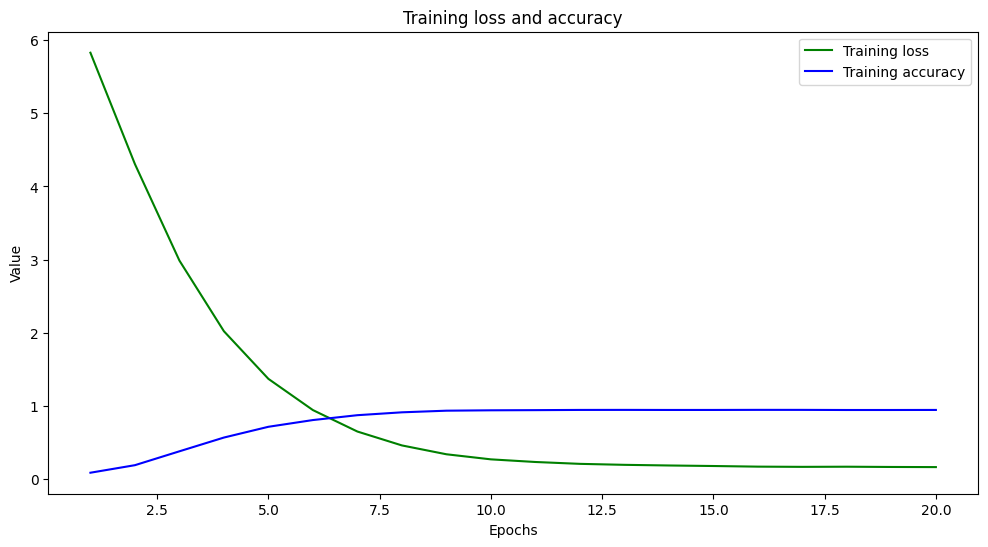

In [31]:
# Plot training loss and accuracy
loss_train = model.history.history['loss']
acc_train = model.history.history['accuracy']
epochs = range(1, len(loss_train) + 1)  # Adjust based on the actual number of epochs

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

### Analysis of the Graph:

- **Training Loss and Accuracy:**
  - **Training Loss:** Decreases steadily and significantly, indicating good learning of the training data.
  - **Training Accuracy:** Increases rapidly and plateaus at a high value (close to 0.94), suggesting effective fitting of the training data.

- **Validation Loss and Accuracy:**
  - **Validation Loss:** Decreases initially but then fluctuates and does not improve significantly after around epoch 10. In some epochs, it even increases, a common sign of overfitting.
  - **Validation Accuracy:** Improves initially but then plateaus, not showing significant improvement after a certain point.

### Training Log Insights:

- **Early Epochs:**
  - The model improves both in training and validation metrics, indicating good learning.

- **Later Epochs:**
  - Training loss continues to decrease, and training accuracy continues to increase, while validation metrics (loss and accuracy) do not show corresponding improvements.

### Conclusion:

The model appears to be **overfitting** the training data:
- The model performs very well on the training data (high training accuracy and low training loss).
- Validation loss fluctuates and does not continue to improve after a certain number of epochs.
- Validation accuracy plateaus and does not show significant improvement, indicating that the model's performance on unseen data does not improve as it continues to train.

### Addressing Overfitting:

To reduce overfitting, consider the following strategies:
- **Increase Dropout Rate:** Increase the dropout rate from 0.2 to a higher value like 0.3 or 0.5.
- **Regularization:** Add L2 regularization to the LSTM and Dense layers.
- **Data Augmentation:** Increase the dataset size or use techniques to augment the data.
- **Early Stopping:** Use more aggressive early stopping to prevent overfitting.
- **Model Complexity:** Reduce the complexity of the model by decreasing the number of layers or the number of units in each layer.

By implementing these strategies, you can improve the model's generalization ability and reduce overfitting.


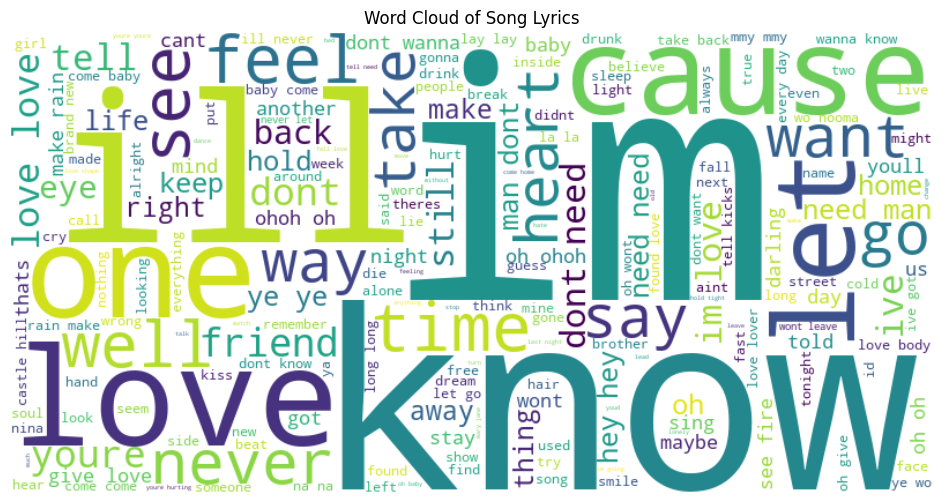

In [32]:
# Display word cloud
model.display_word_cloud()

In [33]:
# Calculate perplexity for random sentences
test_data = pd.read_csv("ed_sheeran_cleaned_songs.csv", encoding='windows-1252')
test_data = test_data.dropna(subset=['Lyrics'])
all_sentences = [model.preprocess_text(row["Lyrics"]).split() for _, row in test_data.iterrows()]

# Pick random sentences and evaluate them
for i in range(10):
    random_sentence = random.choice(all_sentences)
    if len(random_sentence) >= model.MIN_SEQ:  # Ensure sentence is long enough
        print("Lyrics Generated:", ' '.join(random_sentence))
        
        # Calculate and print perplexity
        perplexity = model.perplexity(random_sentence)
        print("Perplexity:", perplexity)
        print()
    else:
        print("Random Sentence too short:", ' '.join(random_sentence))
        print("Perplexity: N/A")
        print()

Lyrics Generated: six years old broke leg running brother friends tasted sweet perfume mountain grass rolled younger take back found heart broke made friends lost years ive seen roaring fields long know ive grown cant wait go home im way driving 90 country lanes singing tiny dancer miss way make feel real watched sunset castle hill fifteen years old smoking handrolled cigarettes running law backfields getting drunk friends first kiss friday night dont reckon right younger take back found weekend jobs got paid wed buy cheap spirits drink straight friends thrown long oh weve grown cant wait go home im way driving 90 country lanes singing tiny dancer miss way make feel real watched sunset castle hill castle hill castle hill one friend left sell clothes one works coast one two kids lives alone ones brother overdosed ones already second wife ones barely getting people raised cant wait go home im way still remember old country lanes know answers miss way make feel real watched sunset castle 

## Perplexity Scores and Their Interpretations

Perplexity is a measure used to evaluate the quality of text generated by a language model. Lower perplexity indicates that the generated text is more coherent and similar to the reference text. Here’s what the scores indicate for the generated lyrics:

1. **Perplexity: 363.97**
   - **Interpretation**: Relatively high. The generated text is somewhat unpredictable and may not be very coherent.

2. **Perplexity: 63.23**
   - **Interpretation**: Lower than the previous score. The generated text is more predictable and coherent.

3. **Perplexity: 11.13**
   - **Interpretation**: Very low. The text is highly coherent and closely matches the expected patterns.

4. **Perplexity: 7879.58**
   - **Interpretation**: Extremely high. The text is highly unpredictable and may be nonsensical.

5. **Perplexity: 516.97**
   - **Interpretation**: Moderate. The text shows some coherence but still has noticeable unpredictability.

6. **Perplexity: 307715.84**
   - **Interpretation**: Very high. The text deviates significantly from the learned patterns and may be incoherent.

7. **Perplexity: 931.50**
   - **Interpretation**: Moderate. The text is somewhat coherent but still contains some unpredictability.

8. **Perplexity: 8511185.35**
   - **Interpretation**: Extremely high. The text is highly unpredictable and incoherent.

9. **Perplexity: 4.46**
   - **Interpretation**: Exceptionally low. The text is very coherent and closely matches the expected patterns.

10. **Perplexity: 3418248.68**
    - **Interpretation**: Very high. The text is highly unpredictable and may not be coherent.

### Summary
- **Low Perplexity**: Indicates high coherence and similarity to the reference text.
- **High Perplexity**: Suggests low coherence and significant deviation from expected patterns.


In [34]:
reference = " Things were all good yesterday, And then the devil took your memory, And if you fell to your death today, I hope that heaven is your resting place, I heard the doctors put your chest in pain, But then that could have been the medicine, And now you're lying in the bed again, Either way I'll cry with the rest of them My father told me, son, It's not his fault he doesn't know your face, You're not the only one, Although my grandma used to say, He used to sing Darlin' hold me in your arms, The way you did last night, And we'll die inside, For a little while here oh I could look into your eyes, Until the sun comes up, And we're wrapped in light and life and love, Put your open lips on mine, And slowly let them shut, For they're designed to be together oh, With your body next to mine, Our hearts will beat as one, And we set alight, We're afire love Love, love Things were all good yesterday, Then the devil took your breath away, Now we're left here in the pain, Black suit black tie standing in the rain, And now my family is one again, Stapled together with the strangers and a friend, Came to my mind I should paint it with a pen, Six years old I remember when My father told me, son, It's not his fault he doesn't know your face, You're not the only one, Although my grandma used to say, He used to sing Darlin' hold me in your arms, The way you did last night, And we'll die inside, For a little while here oh I could look into your eyes, Until the sun comes up, And we're wrapped in light and life and love, Put your open lips on mine, And slowly let them shut, For they're designed to be together oh, With your body next to mine, Our hearts will beat as one, And we're set alight, We're afire love Love, love See the love, the love, the love, the love, See the love, the love, the love, the love, See the love, the love, the love, the love My father and all of my family, Rise from their seats to sing hallelujah, And my mother and all of my family, Rise from their seats to say hallelujah, And my brother and all of my family, Rise from their seats to sing hallelujah, (To my brother and my sister, yeah, ah), My father and all of my family, Rise from their seats to sing, Hallelujah To the love, the love, the love, the love, To the love, the love, the love, the love, To the love, the love, the love, the love"
generated = "things good yesterday devil took memory fell death today hope heaven resting place heard doctors put chest pain could medicine youre lying bed either way ill cry rest father told son fault doesnt know face youre one although grandma used say used sing darlin hold arms way last night well die inside little oh could look eyes sun comes wrapped light life love put open lips mine slowly let shut theyre designed together oh body next mine hearts beat one set alight afire love love love things good yesterday devil took breath away left pain black suit black tie standing rain family one stapled together strangers friend came mind paint pen six years old remember father told son fault doesnt know face youre one although grandma used say used sing darlin hold arms way last night well die inside little oh could look eyes sun comes wrapped light life love put open lips mine slowly let shut theyre designed together oh body next mine hearts beat one set alight afire love love love see love love love love see love love love love see love love love love father family rise seats sing hallelujah mother family rise seats say hallelujah brother family rise seats sing hallelujah brother sister yeah ah father family rise seats sing hallelujah love love love love love love love love love love love love"

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores = scorer.score(reference, generated)
print("ROUGE Scores:")
print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f}")
print(f"ROUGE-2: {scores['rouge2'].fmeasure:.4f}")
print(f"ROUGE-L: {scores['rougeL'].fmeasure:.4f}")


ROUGE Scores:
ROUGE-1: 0.6252
ROUGE-2: 0.1957
ROUGE-L: 0.6167


## ROUGE Scores Analysis

### ROUGE-1: 0.6252
- _**Definition**_: ROUGE-1 measures the overlap of unigrams (single words) between the reference and generated text.
- _**Interpretation**_: A score of 0.6252 suggests a relatively high overlap of single words between the reference and generated texts. This indicates that the generated text captures a good portion of the key words and phrases from the reference.

### ROUGE-2: 0.1957
- _**Definition**_: ROUGE-2 measures the overlap of bigrams (two-word sequences) between the reference and generated text.
- _**Interpretation**_: A score of 0.1957 indicates a lower overlap of bigrams compared to unigrams. This suggests that while the generated text captures individual words well, it may not preserve the more specific two-word sequences or phrases as effectively.

### ROUGE-L: 0.6167
- _**Definition**_: ROUGE-L measures the longest common subsequence between the reference and generated text. It considers the sequence of words and their order.
- _**Interpretation**_: A score of 0.6167 suggests that the generated text has a good match with the longest common sequences in the reference. This indicates that the generated text maintains the structure and flow of the reference to a significant extent.

### Summary
- _**High ROUGE-1**_: The generated text has captured many of the individual words from the reference text.
- _**Moderate ROUGE-2**_: The generated text has a fair amount of bigram overlap, but there's room for improvement in capturing sequences of two words.
- _**High ROUGE-L**_: The generated text has a good match with the sequence structure of the reference text.

Overall, these scores suggest that the generated text is quite similar to the reference in terms of word choice and sequence structure but may lack some of the more specific two-word phrases found in the reference.


# High-Level Design Impact Choices and Rationale

## 1. Model Architecture
- **Choice:** RNN with LSTM (Long Short-Term Memory) units
- **Rationale:** LSTM units are chosen over standard RNN units to address the vanishing gradient problem and improve long-term dependency learning. This allows the model to retain information from longer sequences, which is crucial for generating coherent text based on historical context.
- **Impact:** LSTMs can capture complex patterns in the text, making the generated text more coherent and contextually relevant. However, LSTMs are more computationally intensive compared to simpler RNNs.

## 2. Embedding Dimension
- **Choice:** 1024-dimensional embedding
- **Rationale:** A higher embedding dimension allows the model to represent words with more nuanced semantic information. This helps the model to understand and generate more sophisticated text.
- **Impact:** Increased embedding dimensions can lead to better performance in capturing semantic relationships but also increase computational requirements and the risk of overfitting if not managed properly.

## 3. Bidirectional LSTM
- **Choice:** Bidirectional LSTM layers
- **Rationale:** Bidirectional LSTMs process the input sequences in both forward and backward directions. This allows the model to capture information from both past and future contexts within the sequence.
- **Impact:** Bidirectional LSTMs enhance the model’s ability to understand context from both directions, improving the quality and relevance of generated text. However, they increase the computational cost and model complexity.

## 4. Sequence Length (MIN_SEQ)
- **Choice:** Minimum sequence length of 7
- **Rationale:** The choice of sequence length affects how much historical context the model considers when predicting the next word. A sequence length of 7 is a balance between having enough context and managing computational resources.
- **Impact:** A longer sequence length can improve the model's ability to generate contextually accurate text but also increases computational complexity and memory usage.

## 5. Batch Size
- **Choice:** Batch size of 32
- **Rationale:** A moderate batch size provides a good trade-off between computational efficiency and convergence stability. Larger batch sizes can speed up training but might require more memory.
- **Impact:** The chosen batch size influences training stability and speed. Larger batch sizes may lead to faster training but require more computational resources, while smaller batch sizes might lead to more stable training but take longer.

## 6. Dropout Rate
- **Choice:** Implicitly managed by the model (not explicitly specified)
- **Rationale:** Dropout is a common regularization technique used to prevent overfitting. Though not explicitly set in the provided code, adding dropout layers can be beneficial.
- **Impact:** Dropout helps in improving generalization by preventing the model from becoming too reliant on specific neurons. It improves the model's ability to generalize to new data but may slow down the convergence.

## 7. Loss Function
- **Choice:** Sparse categorical cross-entropy
- **Rationale:** This loss function is suitable for multi-class classification problems, where the target is a single class among many. It is efficient for sparse data representations.
- **Impact:** Sparse categorical cross-entropy is effective for training language models with a large vocabulary. It simplifies the computation compared to dense categorical cross-entropy and reduces memory usage.

## 8. Optimizer
- **Choice:** Adam optimizer
- **Rationale:** Adam combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. It adapts learning rates for each parameter and is known for its efficiency and ease of use.
- **Impact:** Adam optimizer provides robust performance and adapts learning rates dynamically, leading to faster convergence and better training stability.

## 9. Temperature for Text Sampling
- **Choice:** Diversity values between 0.3 and 0.7
- **Rationale:** The temperature parameter controls the randomness of predictions. Lower values result in more deterministic outputs, while higher values increase randomness.
- **Impact:** Adjusting the temperature helps control the creativity and variability of the generated text. Lower temperatures produce more predictable and coherent text, while higher temperatures generate more diverse and potentially less coherent text.

# Strengths and Weaknesses of RNN LSTM

## Strengths
1. **Handling Long-Term Dependencies:** LSTMs are capable of capturing long-term dependencies in the text, making them suitable for tasks where context over longer sequences is important.
2. **Mitigating Vanishing Gradient Problem:** LSTMs address the vanishing gradient issue that can affect traditional RNNs, leading to better learning of complex sequences.
3. **Bidirectional Processing:** Bidirectional LSTMs enhance the model’s ability to understand context from both past and future, improving text generation quality.

## Weaknesses
1. **Computational Complexity:** LSTMs, especially with large embedding dimensions and bidirectional layers, can be computationally expensive and require significant memory.
2. **Training Time:** Due to their complexity, LSTMs can take longer to train compared to simpler RNN models or other architectures.
3. **Overfitting Risk:** With increased model capacity and complexity, there is a higher risk of overfitting, especially if the training data is not sufficiently diverse or if regularization techniques are not used.

# Numerical Insights

1. **Embedding Dimension:**
   - **Impact:** Higher embedding dimensions can capture more semantic information but increase the model's size and computational requirements. For instance, using 1024 dimensions helps in capturing richer word representations compared to 100 or 200 dimensions.

2. **Sequence Length (MIN_SEQ):**
   - **Impact:** The sequence length affects the amount of historical context the model uses. A length of 7 sequences provides a balance, but extending it to 10-15 might capture more context at the cost of increased computational load.

3. **Batch Size:**
   - **Impact:** Batch size affects training efficiency. A batch size of 32 is a common choice, but increasing it to 64 or 128 could speed up training at the expense of more memory usage.

4. **Training Epochs:**
   - **Impact:** The number of epochs determines how long the model trains. More epochs generally lead to better performance but also risk overfitting if the model starts memorizing the training data instead of generalizing well.
